### Load required Libraries

In [1]:
import dask.distributed
import dask.utils
import numpy as np
import planetary_computer as pc
import xarray as xr
from IPython.display import display
from pystac_client import Client
import matplotlib.pyplot as plt
import folium

from odc.stac import configure_rio, stac_load

##### Manually supply band datatype and nodata infromation for each band in the collection. Here we will use the band name '*' as a wildcard

In [2]:
configuration = {
    "sentinel-2-l2a": {
        "assets": {
            "*": {"data_type": "uint16", "nodata": 0},
            "SCL": {"data_type": "uint8", "nodata": 0},
            "visual": {"data_type": "uint8", "nodata": 0},
        },
    },
    "*": {"warnings": "ignore"},
}

##### We load the data into Memory using Dask. It improves the load speed. You are able to see Local cluster information such as total threads being used, total memory available, etc. 

In [3]:
client = dask.distributed.Client()
configure_rio(cloud_defaults=True, client=client)
display(client)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/christobal.tobbin@stud-mail.uni-wuerzburg.de/proxy/8787/status,
Dashboard: /user/christobal.tobbin@stud-mail.uni-wuerzburg.de/proxy/8787/status,Workers: 4
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38873,Workers: 4
Dashboard: /user/christobal.tobbin@stud-mail.uni-wuerzburg.de/proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:39101,Total threads: 2
Dashboard: /user/christobal.tobbin@stud-mail.uni-wuerzburg.de/proxy/34239/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:42019,


##### We call the sentinel 2 l2a data collection over MGRS tile 30PYS in Ghana (Janga). Client being microsoft planetary computer 

In [4]:
data_catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

query = data_catalog.search(
    collections=["sentinel-2-l2a"],#landsat-c2-l2,sentinel-2-l2a 
    datetime="2023-02-10", #cloudfree date
    query={"s2:mgrs_tile": dict(eq="30PYS")},
)

images = list(query.items())
print(f"Found;{len(images):d} datasets")
#we expect a single dataset since we selected a single day

Found;1 datasets


### Now we lazy load the bands

In [5]:
resolution = 10

dataset = stac_load(
    images, chunks={"x":2048, "y":2048},
    stac_cfg=configuration, patch_url=pc.sign,
    resolution=resolution,
)

print(f"Bands: {','.join(list(dataset.data_vars))}")
display(dataset)

Bands: AOT,B01,B02,B03,B04,B05,B06,B07,B08,B09,B11,B12,B8A,SCL,WVP,visual


<xarray.Dataset>
Dimensions:      (y: 10980, x: 10980, time: 1)
Coordinates:
  * y            (y) float64 1.2e+06 1.2e+06 1.2e+06 ... 1.09e+06 1.09e+06
  * x            (x) float64 7e+05 7e+05 7e+05 ... 8.097e+05 8.097e+05 8.098e+05
    spatial_ref  int32 32630
  * time         (time) datetime64[ns] 2023-02-10T10:20:49.024000
Data variables: (12/16)
    AOT          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B01          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B02          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B03          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B04          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B05          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    ...           ...
    B11          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B12          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B8A          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    SCL          (time, y, x) uint8 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    WVP          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    visual       (time, y, x) uint8 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>

### We can call out specific bands we need from the entire bands.

In [6]:
dataset = stac_load(
    images, bands=["red", "green", "blue", "nir", "SCL"],
    chunks={"x":2048, "y":2048},
    stac_cfg=configuration, patch_url=pc.sign,
    resolution=resolution,
)
print(f"Bands: {','.join(list(dataset.data_vars))}")
display(dataset)

Bands: red,green,blue,nir,SCL


<xarray.Dataset>
Dimensions:      (y: 10980, x: 10980, time: 1)
Coordinates:
  * y            (y) float64 1.2e+06 1.2e+06 1.2e+06 ... 1.09e+06 1.09e+06
  * x            (x) float64 7e+05 7e+05 7e+05 ... 8.097e+05 8.097e+05 8.098e+05
    spatial_ref  int32 32630
  * time         (time) datetime64[ns] 2023-02-10T10:20:49.024000
Data variables:
    red          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    nir          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    SCL          (time, y, x) uint8 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>

### To perform some math on the bands we first have to change the datatype

In [7]:
def to_float(dataset):
    dataset_float = dataset.astype("float32")
    nodata= dataset_float.attrs.pop("nodata", None)
    if nodata is None:
        return bands_float
    return dataset_float.where(dataset != nodata)

def colorize(dataset, colormap):
    return xr.DataArray(colormap[dataset.data], coords= dataset.coords, dims=(*dataset.dims, "band"))

### Calculate the NDVI

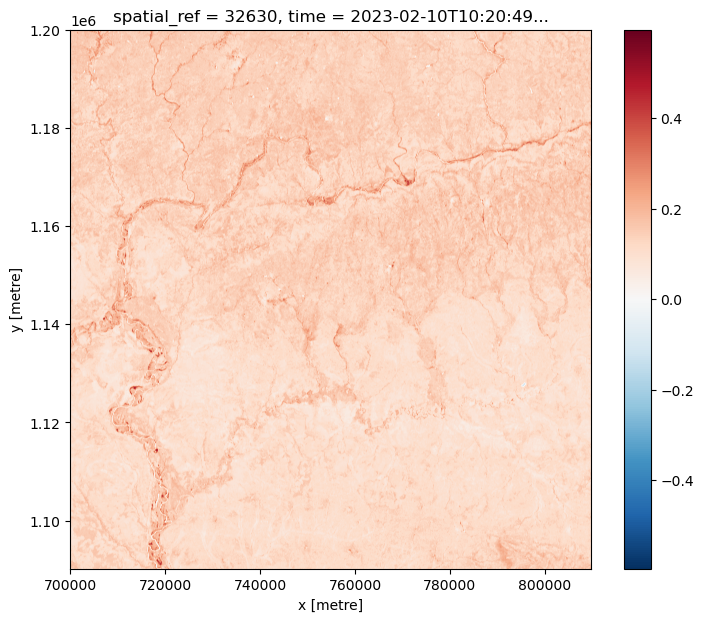

In [8]:
nir = to_float(dataset.nir)
red = to_float(dataset.red)
ndvi = (nir - red)/(nir + red)

#plot
plot = ndvi.isel(time=0).compute().plot.imshow(size=7, aspect=1.2, interpolation="bicubic")

### Calculate the LAI

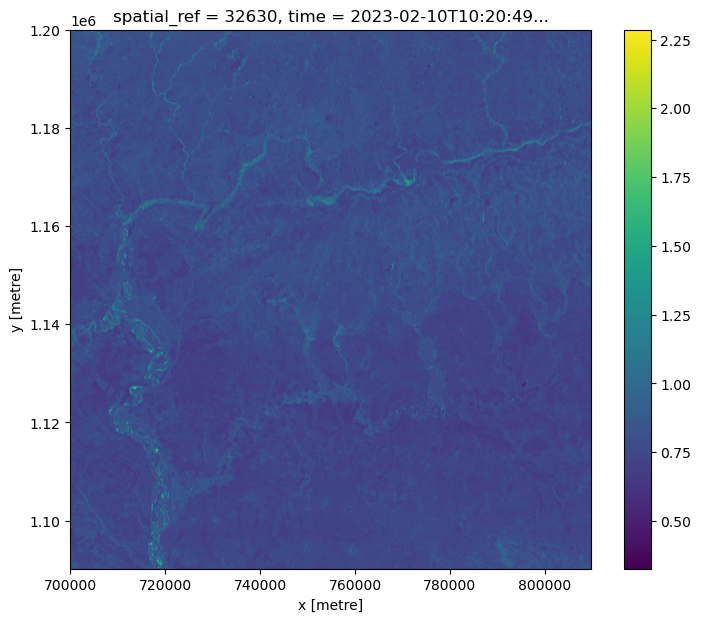

In [9]:
lai = 0.57*np.exp(2.33*ndvi)

#plot
plot = lai.isel(time=0).compute().plot.imshow(size=7, aspect=1.2, interpolation="bicubic")

### Let us load a second image from 2020 and repeat the same steps

In [11]:
query_1 = data_catalog.search(
    collections=["sentinel-2-l2a"],
    datetime="2020-01-02", #cloudfree date 
    query={"s2:mgrs_tile": dict(eq="30PYS")},
)

images_1 = list(query_1.items())
print(f"Found;{len(images_1):d} datasets")

Found;1 datasets


In [12]:
dataset_1 = stac_load(
    images_1, chunks={"x":2048, "y":2048},
    stac_cfg=configuration, patch_url=pc.sign,
    resolution=resolution,
)

print(f"Bands: {','.join(list(dataset_1.data_vars))}")
display(dataset_1)

Bands: AOT,B01,B02,B03,B04,B05,B06,B07,B08,B09,B11,B12,B8A,SCL,WVP,visual


<xarray.Dataset>
Dimensions:      (y: 10980, x: 10980, time: 1)
Coordinates:
  * y            (y) float64 1.2e+06 1.2e+06 1.2e+06 ... 1.09e+06 1.09e+06
  * x            (x) float64 7e+05 7e+05 7e+05 ... 8.097e+05 8.097e+05 8.098e+05
    spatial_ref  int32 32630
  * time         (time) datetime64[ns] 2020-01-02T10:24:21.024000
Data variables: (12/16)
    AOT          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B01          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B02          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B03          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B04          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B05          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    ...           ...
    B11          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B12          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B8A          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    SCL          (time, y, x) uint8 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    WVP          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    visual       (time, y, x) uint8 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>

In [13]:
dataset_1 = stac_load(
    images_1, bands=["red", "green", "blue", "nir", "SCL"],
    chunks={"x":2048, "y":2048},
    stac_cfg=configuration, patch_url=pc.sign,
    resolution=resolution,
)
print(f"Bands: {','.join(list(dataset_1.data_vars))}")
display(dataset_1)

Bands: red,green,blue,nir,SCL


<xarray.Dataset>
Dimensions:      (y: 10980, x: 10980, time: 1)
Coordinates:
  * y            (y) float64 1.2e+06 1.2e+06 1.2e+06 ... 1.09e+06 1.09e+06
  * x            (x) float64 7e+05 7e+05 7e+05 ... 8.097e+05 8.097e+05 8.098e+05
    spatial_ref  int32 32630
  * time         (time) datetime64[ns] 2020-01-02T10:24:21.024000
Data variables:
    red          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    nir          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    SCL          (time, y, x) uint8 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>

In [14]:
def to_float(dataset_1):
    dataset_float_1 = dataset_1.astype("float32")
    nodata_1= dataset_float_1.attrs.pop("nodata", None)
    if nodata_1 is None:
        return bands_float_1
    return dataset_float_1.where(dataset_1 != nodata_1)

def colorize(dataset_1, colormap):
    return xr.DataArray(colormap[dataset_1.data], coords= dataset_1.coords, dims=(*dataset_1.dims, "band"))

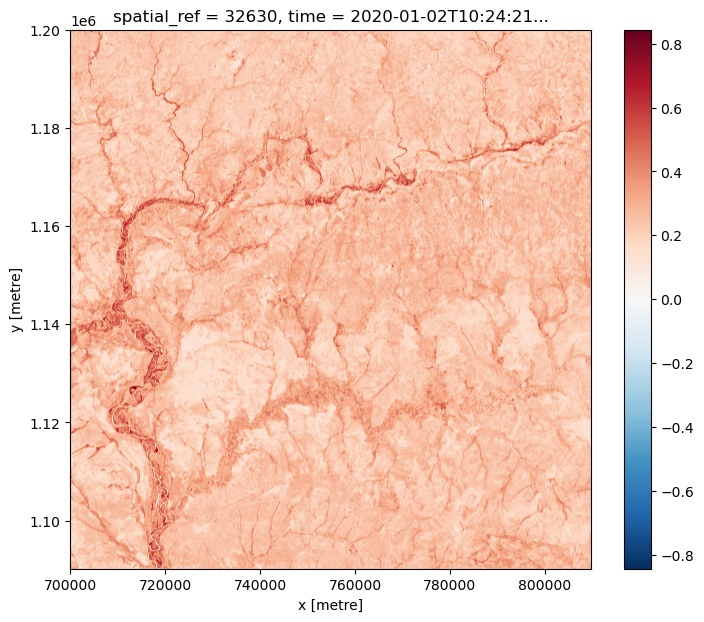

In [15]:
nir = to_float(dataset_1.nir)
red = to_float(dataset_1.red)
ndvi_1 = (nir - red)/(nir + red)

#plot
plot = ndvi_1.isel(time=0).compute().plot.imshow(size=7, aspect=1.2, interpolation="bicubic")

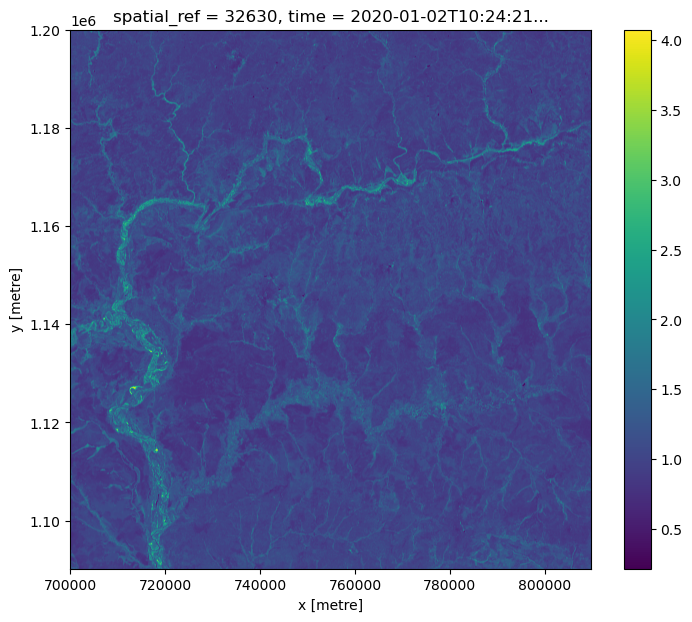

In [17]:
lai_1 = 0.57*np.exp(2.33*ndvi_1)

# plot
plot = lai_1.isel(time=0).compute().plot.imshow(size=7, aspect=1.2, interpolation="bicubic")

#### Let us find the mean values of the NDVIs over the two dates

In [58]:
ndvi_array = ndvi.values
ndvi_array_1 = ndvi_1.values

mean_ndvi = np.mean(ndvi_array)
mean_ndvi_1 = np.mean(ndvi_array_1)

print('Mean LAI :',  mean_ndvi)
print('Mean LAI_1 :',  mean_ndvi_1)

Mean LAI : 0.1285752
Mean LAI_1 : 0.2519004


#### Let us find the standard deviation values of the LAIs over the two dates

In [60]:
std_ndvi = np.std(ndvi_array)
std_ndvi_1 = np.std(ndvi_array_1)

print('Standard deviation LAI :',  std_ndvi)
print('Standard deviation LAI_1 :',  std_ndvi_1)

Standard deviation LAI : 0.042866662
Standard deviation LAI_1 : 0.08545589


#### Plot Histograms of the LAIs

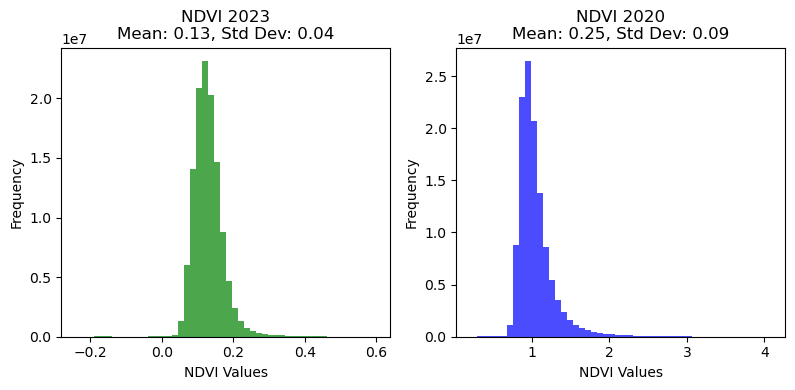

In [63]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.hist(ndvi_array.ravel(), bins=50, color='green', alpha=0.7)
plt.title(f'NDVI 2023\nMean: {mean_ndvi:.2f}, Std Dev: {std_ndvi:.2f}')
plt.xlabel('NDVI Values')
plt.ylabel('Frequency')

plt.subplot(1,3,2)
plt.hist(lai_array_1.ravel(), bins=50, color='blue', alpha=0.7)
plt.title(f'NDVI 2020\nMean: {mean_ndvi_1:.2f}, Std Dev: {std_ndvi_1:.2f}')
plt.xlabel('NDVI Values')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

#### Let us find the mean values of the LAIs over the two dates

In [54]:
lai_array = lai.values
lai_array_1 = lai_1.values

mean_lai = np.mean(lai_array)
mean_lai_1 = np.mean(lai_array_1)

print('Mean LAI :',  mean_lai)
print('Mean LAI_1 :',  mean_lai_1)

Mean LAI : 0.77312833
Mean LAI_1 : 1.0476407


#### Let us find the standard deviation values of the LAIs over the two dates

In [55]:
std_lai = np.std(lai_array)
std_lai_1 = np.std(lai_array_1)

print('Standard deviation LAI :',  std_lai)
print('Standard deviation LAI_1 :',  std_lai_1)

Standard deviation LAI : 0.08413831
Standard deviation LAI_1 : 0.2474938


#### Plot Histograms of the LAIs

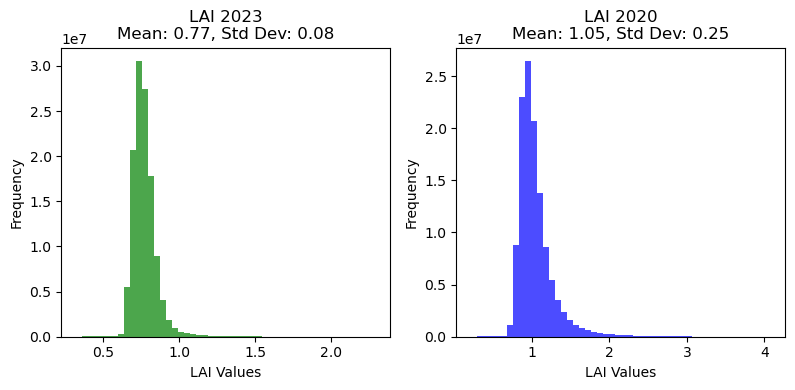

In [62]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.hist(lai_array.ravel(), bins=50, color='green', alpha=0.7)
plt.title(f'LAI 2023\nMean: {mean_lai:.2f}, Std Dev: {std_lai:.2f}')
plt.xlabel('LAI Values')
plt.ylabel('Frequency')

plt.subplot(1,3,2)
plt.hist(lai_array_1.ravel(), bins=50, color='blue', alpha=0.7)
plt.title(f'LAI 2020\nMean: {mean_lai_1:.2f}, Std Dev: {std_lai_1:.2f}')
plt.xlabel('LAI Values')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()